# This Notebook is for the paper submitted to EMBC 2021 and as a preprint on ArXiv.

We implement a framework that is capable of inferring ABP from a single optical photoplethysmogram (PPG). We train our global-model across distributed client-models and data sources to mimic a large-scale distributed collaborative learning experiment that could be implemented across low-cost wearables. Our T2TGAN can map any given time series signal to another but for the transform to make sense the signals should be correlated in some way.


## Import Modules

In [ ]:
import itertools
import datetime
import time
import glob
import random
import sys

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

from tqdm import tqdm
import pickle
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import json as js
from scipy.signal import find_peaks

###Mount your Google Drive

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/T2TGAN/')

Mounted at /content/drive


### Set up GPU

In [ ]:
cuda = torch.cuda.is_available()


#GPU Setup
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    cuda = True
    print('Using: ' + str(torch.cuda.get_device_name(device)))
else:
    cuda = False
    print('Using: CPU')

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

Using: Tesla T4


## Model Definitions

In [ ]:
"""
Created on Tue Dec 03 2019

@author: Eoin Brophy

Notebook for MV time series generation - Model
"""

"""
Generator Class
---------------
This defines the Generator for evaluation. The Generator consists of two LSTM 
layers with a final fully connected layer.
"""
class Generator(nn.Module):
    def __init__(self, seq_len, batch_size, n_features=2, hidden_dim=50,
                 num_layers=2, tanh_output=False):
        super(Generator, self).__init__()
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.n_features = n_features
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.tanh_output = tanh_output

        self.layer1 = nn.LSTM(input_size=self.n_features, hidden_size=self.hidden_dim,
                              num_layers=self.num_layers, batch_first=True,
                              )
        if self.tanh_output == True:
            self.out = nn.Sequential(nn.Linear(self.hidden_dim, self.n_features), nn.Tanh())
        else:
            self.out = nn.Linear(self.hidden_dim, self.n_features)

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.num_layers, self.batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.num_layers, self.batch_size, self.hidden_dim).zero_().to(device))

        return hidden

    def forward(self, input, hidden):
        lstm_out, hidden = self.layer1(input.view(self.batch_size, self.seq_len, -1), hidden)
        lstm_out = self.out(lstm_out)

        return lstm_out


"""
Discriminator Class
---------------
This defines the Discriminator for evaluation. The Discriminator consists of 4 Conv-Pool layers, 
minibatch discrimination layer and a final fully connected layer with sigmoid activation function.
"""
class Discriminator(nn.Module):
    def __init__(self, seq_len, in_channels,
                 cv1_k, cv1_s, p1_k, p1_s,
                 cv2_k, cv2_s, p2_k, p2_s,
                 cv3_k, cv3_s, p3_k, p3_s,
                 cv4_k, cv4_s, p4_k, p4_s):
        super(Discriminator, self).__init__()
        self.seq_len = seq_len
        self.in_channels = in_channels

        self.cv1_k = cv1_k
        self.cv1_s = cv1_s
        self.cv2_k = cv2_k
        self.cv2_s = cv2_s
        self.cv3_k = cv3_k
        self.cv3_s = cv3_s
        self.cv4_k = cv4_k
        self.cv4_s = cv4_s

        self.p1_k = p1_k
        self.p1_s = p1_s
        self.p2_k = p2_k
        self.p2_s = p2_s
        self.p3_k = p3_k
        self.p3_s = p3_s
        self.p4_k = p4_k
        self.p4_s = p4_s

        cp1_out = int((((((seq_len - cv1_k) / cv1_s) + 1) - p1_k) / p1_s) + 1)
        cp2_out = int((((((cp1_out - cv2_k) / cv2_s) + 1) - p2_k) / p2_s) + 1)
        cp3_out = int((((((cp2_out - cv3_k) / cv3_s) + 1) - p3_k) / p3_s) + 1)
        cp4_out = int((((((cp3_out - cv4_k) / cv4_s) + 1) - p4_k) / p4_s) + 1)

        # The first pair of convolution-pooling layer, input size: 2*187*batch_size
        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=3, kernel_size=(cv1_k), stride=(cv1_s)),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=(p1_k), stride=(p1_s))
        )

        # Second convolution - pooling layer
        self.layer2 = nn.Sequential(
            nn.Conv1d(in_channels=3, out_channels=5, kernel_size=(cv2_k), stride=(cv2_s)),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=(p2_k), stride=(p2_s))
        )

        # Third convolution - pooling layer
        self.layer3 = nn.Sequential(
            nn.Conv1d(in_channels=5, out_channels=8, kernel_size=(cv3_k), stride=(cv3_s)),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=(p3_k), stride=(p3_s))
        )
        # Fourth convolution - pooling layer
        self.layer4 = nn.Sequential(
            nn.Conv1d(in_channels=8, out_channels=10, kernel_size=(cv4_k), stride=(cv4_s)),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=(p4_k), stride=(p4_s))
        )


        # Fully connected layer
        self.layer5 = nn.Sequential(
            nn.Linear(10 * cp4_out, 50),
            nn.Linear(50, 50),
            nn.Linear(50, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.size(0), -1)
        output = self.layer5(x)
        return output

### Initialise Parameters for Models and Training

In [ ]:
"""Initialising Parameters"""
def init_params():

  # Number of features
  seq_len = 1000
  batch_size = 32

  # Params for the generator
  hidden_nodes_g = 50
  layers = 2
  tanh_layer = False

  num_epochs = 20
  learning_rate = 0.0002

  # Params for the Discriminator
  num_cvs = 2
  cv1_out= 10
  cv1_k = 3
  cv1_s = 1
  p1_k = 3
  p1_s = 2
  cv2_out = 10
  cv2_k = 3
  cv2_s = 1
  p2_k = 3
  p2_s = 2
  lambda_cyc =  10.0
  lambda_id = 5.0

  # Create Dictionary - for re-use
  params = {
      'seq_len' : seq_len,
      'batch_size' : batch_size,
      'epochs': num_epochs,
      'learning_rate' : learning_rate,
      'num_cvs' : num_cvs,
      'cv1_out' : cv1_out,
      'cv1_k' : cv1_k,
      'cv1_s' : cv1_s,
      'p1_k' : p1_k,
      'p1_s' : p1_s,
      'cv2_out' : cv2_out,
      'cv2_k' : cv2_k,
      'cv2_s' : cv2_s,
      'p2_k' : p2_k,
      'p2_s' : p2_s,
      'lambda_cyc' : lambda_cyc,
      'lambda_id' : lambda_id
  }

  return params

### Replay Buffer

For calling previously generated samples

In [ ]:
class ReplayBuffer:
    def __init__(self, max_size=50):
        assert max_size > 0, "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

## Helper Functions for Federated Learning

Taken from [here](https://towardsdatascience.com/preserving-data-privacy-in-deep-learning-part-1-a04894f78029)


1.   **num_clients**: Total number of clients, further this is used to divide the dataset into num_clients with every client, having the same amount of images.

2.   **num_selected**: Number of randomly selected clients from num_clients during communication round. To be used in the training section. Generally, num_selected is around 30% of the num_clients.

3.   **num_rounds**: Total number of communication rounds. In each communication round, num_clients are randomly selected, training on client’s devices takes place, which is followed by aggregation of the individual model weights into one global model.
4.   **epochs**: Total number of local training rounds on each selected client’s device.
5.   **batch_size**: Loading the data into the data loader by batches.













In [ ]:
##### Hyperparameters for federated learning #########
num_clients = 20
num_selected = 6
num_rounds = 10
epochs = 5
batch_size = 32

### Client Update: client-models training function
The client_update function trains the client model on private client data. This is the local training round that takes place at num_selected clients, i.e. 6 in our case.

In [ ]:
def client_update(client_G_AB, client_G_BA, client_D_A, client_D_B,
                  optimizer_G, optimizer_D_A, optimizer_D_B, 
                  train_loader, params, epoch=5):
    """
    This function updates/trains client model on client data
    """
    client_G_AB.train()
    client_G_BA.train()

    client_D_A.train()
    client_D_B.train()
    for e in range(epoch):
        for batch_idx, sample_data in enumerate(train_loader):
          # Set model input
          real_A = Variable(sample_data["A"].type(Tensor))
          real_B = Variable(sample_data["B"].type(Tensor))
          
          # Adversarial GT
          valid = Variable(Tensor(real_A.size(0), 1).fill_(1.0), requires_grad=False)
          fake = Variable(Tensor(real_A.size(0), 1).fill_(0.0), requires_grad=False)
          # ------------------
          #  Train Generators
          # ------------------
          optimizer_G.zero_grad()
          h_g_AB = client_G_AB.init_hidden()
          h_g_BA = client_G_BA.init_hidden()

          # Identity Loss (A,A) and (B,B)
          id_AA = client_G_BA(real_A, h_g_BA)
          id_AA = id_AA.view(params['batch_size'], -1, params['seq_len'])
          id_BB = client_G_AB(real_B, h_g_AB)
          id_BB = id_BB.view(params['batch_size'], -1, params['seq_len'])

          loss_id_A = criterion_identity(id_AA, real_A)
          loss_id_B = criterion_identity(id_BB, real_B)
                      
          loss_identity = (loss_id_A + loss_id_B) / 2

          # GAN loss
          fake_B = client_G_AB(real_A, h_g_AB)
          fake_B = fake_B.view(params['batch_size'], -1, params['seq_len'])
          loss_GAN_AB = criterion_GAN(client_D_B(fake_B), valid)

          fake_A = client_G_BA(real_B, h_g_BA)
          fake_A = fake_A.view(params['batch_size'], -1, params['seq_len'])
          loss_GAN_BA = criterion_GAN(client_D_A(fake_A), valid)

          loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

          # Cycle loss
          recov_A = client_G_BA(fake_B, h_g_BA)
          recov_A = recov_A.view(params['batch_size'], -1, params['seq_len'])
          loss_cycle_A = criterion_cycle(recov_A, real_A)
          recov_B = client_G_AB(fake_A, h_g_AB)
          recov_B = recov_B.view(params['batch_size'], -1, params['seq_len'])
          loss_cycle_B = criterion_cycle(recov_B, real_B)

          loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

          # Total loss
          loss_G = loss_GAN + params['lambda_cyc'] * loss_cycle + params['lambda_id'] * loss_identity

          loss_G.backward()
          optimizer_G.step()

          # -----------------------
          #  Train Discriminator A
          # -----------------------
          optimizer_D_A.zero_grad()

          # Real loss
          loss_real = criterion_GAN(client_D_A(real_A), valid)
          # Fake loss (on batch of previously generated samples)
          fake_A_ = fake_A_buffer.push_and_pop(fake_A)
          loss_fake = criterion_GAN(client_D_A(fake_A_.detach()), fake)
          # Total loss
          loss_D_A = (loss_real + loss_fake) / 2

          loss_D_A.backward()
          optimizer_D_A.step()

          # -----------------------
          #  Train Discriminator B
          # -----------------------
          optimizer_D_B.zero_grad()

          # Real loss
          loss_real = criterion_GAN(client_D_B(real_B), valid)
          # Fake loss (on batch of previously generated samples)
          fake_B_ = fake_B_buffer.push_and_pop(fake_B)
          loss_fake = criterion_GAN(client_D_B(fake_B_.detach()), fake)
          # Total loss
          loss_D_B = (loss_real + loss_fake) / 2

          loss_D_B.backward()
          optimizer_D_B.step()

          loss_D = (loss_D_A + loss_D_B) / 2

    return loss_G.item(), loss_D.item()

###Server Aggregate: aggregates client-model weights

The server_aggregate function aggregates the model weights received from every client and updates the global model with the updated weights. In this tutorial, the mean of the weights is taken and aggregated into the global weights.


In [ ]:
def server_aggregate(global_G_AB, global_G_BA, global_D_A, global_D_B, 
                     client_G_AB, client_G_BA, client_D_A, client_D_B):
    ### This will take simple mean of the weights of G_AB ###
      global_dict_G_AB = global_G_AB.state_dict()
      for k in global_dict_G_AB.keys():
          global_dict_G_AB[k] = torch.stack([client_G_AB[i].state_dict()[k].float() for i in range(len(client_G_AB))], 0).mean(0)
      global_G_AB.load_state_dict(global_dict_G_AB)
      for model_G_AB in client_G_AB:
          model_G_AB.load_state_dict(global_G_AB.state_dict())

    ### This will take simple mean of the weights of models ###
      global_dict_G_BA = global_G_BA.state_dict()
      for k in global_dict_G_BA.keys():
          global_dict_G_BA[k] = torch.stack([client_G_BA[i].state_dict()[k].float() for i in range(len(client_G_BA))], 0).mean(0)
      global_G_BA.load_state_dict(global_dict_G_BA)
      for model_G_BA in client_G_BA:
          model_G_BA.load_state_dict(global_G_BA.state_dict())

    ### This will take simple mean of the weights of models ###
      global_dict_D_A = global_D_A.state_dict()
      for k in global_dict_D_A.keys():
          global_dict_D_A[k] = torch.stack([client_D_A[i].state_dict()[k].float() for i in range(len(client_D_A))], 0).mean(0)
      global_D_A.load_state_dict(global_dict_D_A)
      for model_D_A in client_D_A:
          model_D_A.load_state_dict(global_D_A.state_dict())

    ### This will take simple mean of the weights of models ###
      global_dict_D_B = global_D_B.state_dict()
      for k in global_dict_D_B.keys():
          global_dict_D_B[k] = torch.stack([client_D_B[i].state_dict()[k].float() for i in range(len(client_D_B))], 0).mean(0)
      global_D_B.load_state_dict(global_dict_D_B)
      for model_D_B in client_D_B:
          model_D_B.load_state_dict(global_D_B.state_dict())

## Other Function Definitions

### Save Parameters

In [ ]:
def save_params(params, filename):
    json = js.dumps(params)
    f = open(filename+'/parameters.json','w')
    f.write(json)
    f.close()

###Load Training Data

In [ ]:
def load_Kaggle_data(seq_len=1000, num_clients = 20):

  train_A_data_1 = torch.load('/content/drive/My Drive/Kaggle/PPG_Part_1.pt')
  train_A_data_2 = torch.load('/content/drive/My Drive/Kaggle/PPG_Part_2.pt')
  train_A_data_3 = torch.load('/content/drive/My Drive/Kaggle/PPG_Part_3.pt')
  train_A_data_4 = torch.load('/content/drive/My Drive/Kaggle/PPG_Part_4.pt')
  train_A_data_5 = torch.load('/content/drive/My Drive/Kaggle/PPG_Part_5.pt')

  train_A_data = np.concatenate((train_A_data_1, train_A_data_2,train_A_data_3,
                                 train_A_data_4,train_A_data_5), axis=0)
  # Removing end of dataset to fit our data to the dataloader
  train_A_data = np.array(train_A_data[:-601], dtype=np.float32)
  train_A_data = torch.tensor(train_A_data)
  train_A_data = train_A_data.view(-1, 1, seq_len)


  train_B_data_1 = torch.load('/content/drive/My Drive/Kaggle/ABP_scale_Part_1.pt')
  train_B_data_2 = torch.load('/content/drive/My Drive/Kaggle/ABP_scale_Part_2.pt')
  train_B_data_3 = torch.load('/content/drive/My Drive/Kaggle/ABP_scale_Part_3.pt')
  train_B_data_4 = torch.load('/content/drive/My Drive/Kaggle/ABP_scale_Part_4.pt')
  train_B_data_5 = torch.load('/content/drive/My Drive/Kaggle/ABP_scale_Part_5.pt')

  train_B_data = np.concatenate((train_B_data_1, train_B_data_2, train_B_data_3,
                                 train_B_data_4, train_B_data_5), axis=0)
  # Removing end of dataset to fit our data to the dataloader
  train_B_data = np.array(train_B_data[:-601], dtype=np.float32)
  train_B_data = torch.tensor(train_B_data)
  train_B_data = train_B_data.view(-1, 1, seq_len)
  #print(train_B_data.shape)

  # Set up data into it's 'domain' "A" = PPG data and "B" = ABP data
  data = []
  for i in range(len(train_A_data)):
    data.append({"A": train_A_data[i], "B": train_B_data[i]})

  # Dividing the training data into num_clients, with each client having equal number of images
  traindata_split = torch.utils.data.random_split(data, [int(len(data) / num_clients) for _ in range(num_clients)])
  # Creating a pytorch loader for a Deep Learning model
  dataloader = [DataLoader(x, batch_size=32, shuffle=True, num_workers=8) for x in traindata_split]

  return dataloader, len(dataloader)  

###Load Validation/Test Data

In [ ]:
def load_test_data():

  train_A_data = torch.load('./ABP_testset/PPG_total_test.pt')
  train_B_data = torch.load('./ABP_testset/ABP_total_test.pt')


  train_A_data = np.array(train_A_data, dtype=np.float32)
  train_A_data = torch.tensor(train_A_data)
  train_A_data = train_A_data.view(-1, 1, 1000)

  train_B_data = np.array(train_B_data, dtype=np.float32)
  train_B_data = torch.tensor(train_B_data)
  train_B_data = train_B_data.view(-1, 1, 1000)

  # Set up data into it's 'domain' "A" = PPG data and "B" = ABP data
  data = []
  for i in range(len(train_A_data)):
    data.append({"A": train_A_data[i], "B": train_B_data[i]})

  # data loader - this batch size is just for testing ...
  # - doesn't impact training
  dataloader = DataLoader(
      data,
      batch_size=5,
      shuffle=True,
      num_workers=8,
  )

  return dataloader, len(dataloader)

### Load Global Models

Loads the Global models and sets up their optimisers!

In [ ]:
def load_model(params):

    G_AB = Generator(params['seq_len'], params['batch_size'], n_features=1, hidden_dim = 50, tanh_output = False).to(device)
    G_BA = Generator(params['seq_len'], params['batch_size'], n_features=1, hidden_dim = 50, tanh_output = False).to(device)

    # You can edit the kernel and filter sizes to accept the params dict.
    # i.e: cv1_k = 3 becomes cv1_k = params['cv1_k'] and so on...

    D_A = Discriminator(params['seq_len'], in_channels=1,
                              cv1_k=3, cv1_s=1, p1_k=3, p1_s=1,
                              cv2_k=3, cv2_s=1, p2_k=3, p2_s=2,
                              cv3_k=3, cv3_s=2, p3_k=3, p3_s=2,
                              cv4_k=5, cv4_s=2, p4_k=5, p4_s=2).to(device)
                              
    D_B = Discriminator(params['seq_len'], in_channels=1,
                              cv1_k=3, cv1_s=1, p1_k=3, p1_s=1,
                              cv2_k=3, cv2_s=1, p2_k=3, p2_s=2,
                              cv3_k=3, cv3_s=2, p3_k=3, p3_s=2,
                              cv4_k=5, cv4_s=2, p4_k=5, p4_s=2).to(device)
    
    
    return G_AB, G_BA, D_A, D_B

### Training Function

In [ ]:
# Losses
criterion_GAN = nn.MSELoss().to(device)
criterion_cycle = nn.L1Loss().to(device)
criterion_identity = nn.L1Loss().to(device)

# Buffers of previously generated samples
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

def train_LSgan(params, savepath = '/content/drive/My Drive/PlethGAN/Fed_LSTM_Results/'):
    # Load training data
    data_loader, num_batches = load_Kaggle_data()
    # Save Parameters
    save_params(params, savepath)

    G_losses = []
    D_losses =[]
    # Load model
    
    ############################################
    #### Initializing models and optimizer  ####
    ############################################ 

    #### global models - if training from epoch 0 ##########
    global_G_AB, global_G_BA, global_D_A, global_D_B = load_model(params)

    #### global models - if training from epoch 1+ ##########
    #global_G_AB.load_state_dict(torch.load(savepath+'/gen/G_AB_state_2.pt'))
    #global_G_BA.load_state_dict(torch.load(savepath+'/gen/G_BA_state_2.pt'))

    #global_D_A.load_state_dict(torch.load(savepath+'/disc/D_A_state_2.pt'))
    #global_D_B.load_state_dict(torch.load(savepath+'/disc/D_B_state_2.pt'))

    ############## client models ##############
    client_G_AB = [Generator(params['seq_len'], params['batch_size'], 
                             n_features=1, hidden_dim = 50, 
                             tanh_output = False).to(device) for _ in range(num_selected)]
    client_G_BA = [Generator(params['seq_len'], params['batch_size'], 
                             n_features=1, hidden_dim = 50, 
                             tanh_output = False).to(device) for _ in range(num_selected)]

    client_D_A = [Discriminator(params['seq_len'], in_channels=1,
                              cv1_k=3, cv1_s=1, p1_k=3, p1_s=1,
                              cv2_k=3, cv2_s=1, p2_k=3, p2_s=2,
                              cv3_k=3, cv3_s=2, p3_k=3, p3_s=2,
                              cv4_k=5, cv4_s=2, p4_k=5, p4_s=2).to(device) for _ in range(num_selected)]
                              
    client_D_B = [Discriminator(params['seq_len'], in_channels=1,
                              cv1_k=3, cv1_s=1, p1_k=3, p1_s=1,
                              cv2_k=3, cv2_s=1, p2_k=3, p2_s=2,
                              cv3_k=3, cv3_s=2, p3_k=3, p3_s=2,
                              cv4_k=5, cv4_s=2, p4_k=5, p4_s=2).to(device) for _ in range(num_selected)]

    ### initial synchronizing with global models
    for model_G_AB in client_G_AB:
        model_G_AB.load_state_dict(global_G_AB.state_dict()) 

    for model_G_BA in client_G_BA:
        model_G_BA.load_state_dict(global_G_BA.state_dict()) 

    for model_D_A in client_D_A:
        model_D_A.load_state_dict(global_D_A.state_dict()) 

    for model_D_B in client_D_B:
        model_D_B.load_state_dict(global_D_B.state_dict()) 


    ############### optimizers ################
    opt_G = [torch.optim.Adam(
        itertools.chain(model_G_AB.parameters(), model_G_BA.parameters()), lr = params['learning_rate'], betas=(0.5, 0.999)
    ) for model_G_AB, model_G_BA in zip(client_G_AB, client_G_BA)]

    opt_D_A = [torch.optim.Adam(model_D_A.parameters(), lr = params['learning_rate'], betas=(0.5, 0.999)) for model_D_A in client_D_A]

    opt_D_B = [torch.optim.Adam(model_D_B.parameters(), lr = params['learning_rate'], betas=(0.5, 0.999)) for model_D_B in client_D_B]

    start_epoch = 0 
    for r in range(start_epoch, num_rounds):
      # select random number of clients
      client_idx = np.random.permutation(num_clients)[:num_selected]
      # client update
      Loss_G = 0
      Loss_D = 0

      for i in tqdm(range(num_selected)):
          tempLoss_G, tempLoss_D = client_update(client_G_AB[i], client_G_BA[i], client_D_A[i], client_D_B[i],
                                          opt_G[i], opt_D_A[i], opt_D_B[i], 
                                          data_loader[client_idx[i]], params, epoch=epochs)
          Loss_G += tempLoss_G
          Loss_D += tempLoss_D
      
      G_losses.append(Loss_G)
      D_losses.append(Loss_D)

      # server aggregate
      server_aggregate(global_G_AB, global_G_BA, global_D_A, global_D_B, 
                       client_G_AB, client_G_BA, client_D_A, client_D_B)
      

      print('\nRound %d of %d' %(r, num_rounds))
      print('average G loss %0.3g | average D loss %0.3g |' % (Loss_G / num_selected, Loss_D / num_selected))

      torch.save(global_G_AB.state_dict(), savepath+'/gen/G_AB_state_'+str(r)+'.pt')
      torch.save(global_G_BA.state_dict(), savepath+'/gen/G_BA_state_'+str(r)+'.pt')

      torch.save(global_D_A.state_dict(), savepath+'/disc/D_A_state_'+str(r)+'.pt')
      torch.save(global_D_B.state_dict(), savepath+'/disc/D_B_state_'+str(r)+'.pt')

## Main - calls training function

In [ ]:
# Initialise Parameters
parameters = init_params()
# Choose GAN function to use
train_LSgan(params=parameters)

## Testing the models for BP measurements


### Load global-models and test dataset

In [ ]:
# Load two generators and validation data
val_dataloader, verbose = load_test_data()
params = init_params()

savepath = '/content/drive/My Drive/PlethGAN/Fed_LSTM_Results/'

G_AB = Generator(params['seq_len'], batch_size = 5, 
                 n_features=1, hidden_dim = 50,
                 tanh_output = False).to(device) 
G_AB.load_state_dict(torch.load(savepath+'/gen/G_AB_state_10.pt'))

G_BA = Generator(params['seq_len'], batch_size = 5,
                 n_features=1, hidden_dim = 50,
                 tanh_output = False).to(device) 
G_BA.load_state_dict(torch.load(savepath+'/gen/G_BA_state_10.pt'))

torch.Size([55590, 1, 1000])


<All keys matched successfully>

In [ ]:
G_AB.eval()
G_BA.eval()

h_g_AB = G_AB.init_hidden()
h_g_BA = G_BA.init_hidden()

### Setup test loop

In [ ]:
def test_BP_Gen(val_dataloader,G_AB, h_AB,
                x_max = 200 , x_min = 40.0):
  y_true = []
  y_preds = []

  s_r = []
  s_f = []
  d_r = []
  d_f = []

  for n_batch, sample_data in enumerate(val_dataloader):
    real_PPG = Variable(sample_data["A"].type(Tensor))
    fake_ABP = G_AB(real_PPG[:,:,:], h_AB)
    fake_ABP = fake_ABP.view(5, -1, 1000)

    real_ABP = Variable(sample_data["B"].type(Tensor))

    for i in range(len(real_PPG)):
      fakeabp = G_AB(real_PPG[:,:,:], h_AB)
      fakeabp = fakeabp.view(5, -1, 1000)

      realabp = (real_ABP[i,0,:]*(x_max - x_min) + x_min)
      fakeabp = (fake_ABP[i,0,:]*(x_max - x_min) +x_min)

      x = realabp.detach().cpu().numpy()
      y = fakeabp.detach().cpu().numpy()

      # Use scipy.signal.find_peaks to find peaks and troughs of ABP signal,
      # TODO: needs more rigourous testing of finding peak and troughs as 
      # the input and generated data can be noisy
      peaks_x, _ = find_peaks(x, height=(max(x) - max(x)*0.2), distance=50)
      troughs_x, _= find_peaks(-x, height = -(min(x) + min(x)*0.2), distance=50)

      peaks_y, _ = find_peaks(y, height=(max(y) - max(y)*0.2), distance=50)
      troughs_y, _= find_peaks(-y, height = -(min(y) + min(y)*0.2), distance=50)

      systolic_real = np.mean(x[peaks_x])
      dystolic_real = np.mean(x[troughs_x])

      systolic_fake = np.mean(y[peaks_y])
      dystolic_fake = np.mean(y[troughs_y])

      # You can opt to use the MAP formula as in the paper OR ...
      ###   you can use the mean of the signal
      MAP_real = np.mean(x)#(systolic_real + 2*(dystolic_real))/3
      MAP_fake = np.mean(y)#(systolic_fake + 2*(dystolic_fake))/3

      # If any NaN skip them.
      if np.isnan(MAP_real)  or np.isnan(MAP_fake) == True:
        print(MAP_real, MAP_fake)
      else:
        y_true.append(MAP_real)
        y_preds.append(MAP_fake) 

        s_r.append(systolic_real)
        s_f.append(systolic_fake)

        d_r.append(dystolic_real)
        d_f.append(dystolic_fake)       

      sys.stdout.write(
                "\r[Batch %d/%d] "
                % (
                    n_batch,
                    len(val_dataloader),
                )
            )

  return y_true, y_preds, s_r, s_f, d_r, d_f

In [ ]:
y_true, y_preds, SP_r, SP_f, DP_r, DP_f = test_BP_Gen(val_dataloader,
                                                      G_AB, h_g_AB, 
                                                      x_max = 200, x_min = 40)

[Batch 50/11118] 

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


[Batch 11117/11118] 

Simply print out if and where any values are NaN

In [ ]:
print(len(y_true))
print(len(y_preds))

print(np.isnan(y_true).any())
print(np.isnan(y_preds).any())

print(np.argwhere(np.isnan(y_true)))

55590
55590
False
False
[]


Run test loop which returns estimated and GT MAP

In [ ]:
score = []
for i in range(len(y_true)):
  score.append(abs(y_true[i]-y_preds[i]))

print("Average MAP error of: %f mmHG" %(np.mean(score)))

Average MAP error of: 12.769598 mmHG


### Calibration on first 1-minute period

In [ ]:
diff = abs(np.array(y_true[:6]) - np.array(y_preds[:6]))

print(np.mean(diff))

12.695697


###Bland-Altman Plot from pyCompare

In [ ]:
!pip install pyCompare
from pyCompare import blandAltman

In [ ]:
# Our predictions after first 10 seconds minus the calibration bias
x = (np.array(y_preds[6:]) - np.mean(diff)).tolist()

In [ ]:
blandAltman(y_true[6:], x,
            limitOfAgreement=1.96,
            confidenceInterval=95,
            confidenceIntervalMethod='approximate',
            detrend=None,
            percentage=False)

### Plotting Function - custom BA plot

This cell allows for more customization of the BA plot compared to PyCompare. 

Authors of this cell: \\
@Raphael Vallat \\
@Nicolas Legrand 

In [ ]:
"""Plotting functions.

Authors
- Raphael Vallat <raphaelvallat9@gmail.com>
- Nicolas Legrand <legrand@cyceron.fr>
"""
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms

# Set default Seaborn preferences (disabled Pingouin >= 0.3.4)
# See https://github.com/raphaelvallat/pingouin/issues/85
# sns.set(style='ticks', context='notebook')

__all__ = ["plot_blandaltman", "qqplot", "plot_paired",
           "plot_shift", "plot_rm_corr", "plot_circmean"]


def plot_blandaltman(x, y, agreement=1.96, confidence=.95, figsize=(10, 7),
                     dpi=72, savePath = './MAP_BA_LSTM_full_cal.pdf', ax=None):
    """
    Generate a Bland-Altman plot to compare two sets of measurements.

    Parameters
    ----------
    x, y : np.array or list
        First and second measurements.
    agreement : float
        Multiple of the standard deviation to plot limit of agreement bounds.
        The defaults is 1.96.
    confidence : float
        If not ``None``, plot the specified percentage confidence interval on
        the mean and limits of agreement.
    figsize : tuple
        Figsize in inches
    dpi : int
        Resolution of the figure in dots per inches.
    ax : matplotlib axes
        Axis on which to draw the plot

    Returns
    -------
    ax : Matplotlib Axes instance
        Returns the Axes object with the plot for further tweaking.

    Notes
    -----
    Bland-Altman plots [1]_ are extensively used to evaluate the agreement
    among two different instruments or two measurements techniques.
    They allow identification of any systematic difference between the
    measurements (i.e., fixed bias) or possible outliers.

    The mean difference is the estimated bias, and the SD of the differences
    measures the random fluctuations around this mean. If the mean value of the
    difference differs significantly from 0 on the basis of a 1-sample t-test,
    this indicates the presence of fixed bias. If there is a consistent bias,
    it can be adjusted for by subtracting the mean difference from the new
    method.

    It is common to compute 95% limits of agreement for each comparison
    (average difference ± 1.96 standard deviation of the difference), which
    tells us how far apart measurements by 2 methods were more likely to be
    for most individuals. If the differences within mean ± 1.96 SD are not
    clinically important, the two methods may be used interchangeably.
    The 95% limits of agreement can be unreliable estimates of the population
    parameters especially for small sample sizes so, when comparing methods
    or assessing repeatability, it is important to calculate confidence
    intervals for 95% limits of agreement.

    The code is an adaptation of the
    `PyCompare <https://github.com/jaketmp/pyCompare>`_ package. The present
    implementation is a simplified version; please refer to the original
    package for more advanced functionalities.

    References
    ----------
    .. [1] Bland, J. M., & Altman, D. (1986). Statistical methods for assessing
           agreement between two methods of clinical measurement. The lancet,
           327(8476), 307-310.

    Examples
    --------
    Bland-Altman plot

    .. plot::

        >>> import numpy as np
        >>> import pingouin as pg
        >>> np.random.seed(123)
        >>> mean, cov = [10, 11], [[1, 0.8], [0.8, 1]]
        >>> x, y = np.random.multivariate_normal(mean, cov, 30).T
        >>> ax = pg.plot_blandaltman(x, y)
    """
    # Safety check
    x = np.asarray(x)
    y = np.asarray(y)
    assert x.ndim == 1 and y.ndim == 1
    assert x.size == y.size
    n = x.size
    mean = np.vstack((x, y)).mean(0)
    diff = x - y
    md = diff.mean()
    sd = diff.std(axis=0, ddof=1)

    # Confidence intervals
    if confidence is not None:
        assert 0 < confidence < 1
        ci = dict()
        ci['mean'] = stats.norm.interval(confidence, loc=md,
                                         scale=sd / np.sqrt(n))
        seLoA = ((1 / n) + (agreement**2 / (2 * (n - 1)))) * (sd**2)
        loARange = np.sqrt(seLoA) * stats.t.ppf((1 - confidence) / 2, n - 1)
        ci['upperLoA'] = ((md + agreement * sd) + loARange,
                          (md + agreement * sd) - loARange)
        ci['lowerLoA'] = ((md - agreement * sd) + loARange,
                          (md - agreement * sd) - loARange)

    # Start the plot
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)

    # Plot the mean diff, limits of agreement and scatter
    ax.axhline(md, color='#6495ED', linestyle='--')
    ax.axhline(md + agreement * sd, color='coral', linestyle='--')
    ax.axhline(md - agreement * sd, color='coral', linestyle='--')
    ax.scatter(mean, diff, alpha=0.4, c='#6495ED')

    loa_range = (md + (agreement * sd)) - (md - agreement * sd)
    offset = (loa_range / 100.0) * 1.5

    trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)

    ax.text(0.98, md + offset, 'Mean', ha="right", va="bottom",
            transform=trans)
    ax.text(0.98, md - offset, '%.2f' % md, ha="right", va="top",
            transform=trans)

    ax.text(0.98, md + (agreement * sd) + offset, '+%.2f SD' % agreement,
            ha="right", va="bottom", transform=trans)
    ax.text(0.98, md + (agreement * sd) - offset,
            '%.2f' % (md + agreement * sd), ha="right", va="top",
            transform=trans)

    ax.text(0.98, md - (agreement * sd) - offset, '-%.2f SD' % agreement,
            ha="right", va="top", transform=trans)
    ax.text(0.98, md - (agreement * sd) + offset,
            '%.2f' % (md - agreement * sd), ha="right", va="bottom",
            transform=trans)

    if confidence is not None:
        ax.axhspan(ci['mean'][0], ci['mean'][1],
                   facecolor='#6495ED', alpha=0.2)

        ax.axhspan(ci['upperLoA'][0], ci['upperLoA'][1],
                   facecolor='coral', alpha=0.2)

        ax.axhspan(ci['lowerLoA'][0], ci['lowerLoA'][1],
                   facecolor='coral', alpha=0.2)

    # Labels and title
    ax.set_ylabel('Error in Prediction (mmHg)')
    ax.set_xlabel('Mean of true and predicted value (mmHg)')
    ax.set_title('Bland-Altman MAP')

    # Despine and trim
    sns.despine(trim=True, ax=ax)

    fig.savefig(savePath, format='pdf', dpi=dpi)

    return ax



def _ppoints(n, a=0.5):
    """
    Ordinates For Probability Plotting.

    Numpy analogue or `R`'s `ppoints` function.

    Parameters
    ----------
    n : int
        Number of points generated
    a : float
        Offset fraction (typically between 0 and 1)

    Returns
    -------
    p : array
        Sequence of probabilities at which to evaluate the inverse
        distribution.
    """
    a = 3 / 8 if n <= 10 else 0.5
    return (np.arange(n) + 1 - a) / (n + 1 - 2 * a)


def qqplot(x, dist='norm', sparams=(), confidence=.95, figsize=(5, 4),
           ax=None):
    """Quantile-Quantile plot.

    Parameters
    ----------
    x : array_like
        Sample data.
    dist : str or stats.distributions instance, optional
        Distribution or distribution function name. The default is `'norm'`
        for a normal probability plot.
    sparams : tuple, optional
        Distribution-specific shape parameters (shape parameters, location,
        and scale). See :py:func:`scipy.stats.probplot` for more details.
    confidence : float
        Confidence level (.95 = 95%) for point-wise confidence envelope.
        Can be disabled by passing False.
    figsize : tuple
        Figsize in inches
    ax : matplotlib axes
        Axis on which to draw the plot

    Returns
    -------
    ax : Matplotlib Axes instance
        Returns the Axes object with the plot for further tweaking.

    Raises
    ------
    ValueError
        If ``sparams`` does not contain the required parameters for ``dist``.
        (e.g. :py:class:`scipy.stats.t` has a mandatory degrees of
        freedom parameter *df*.)

    Notes
    -----
    This function returns a scatter plot of the quantile of the sample data
    ``x`` against the theoretical quantiles of the distribution given in
    ``dist`` (default = *'norm'*).

    The points plotted in a Q–Q plot are always non-decreasing when viewed
    from left to right. If the two distributions being compared are identical,
    the Q–Q plot follows the 45° line y = x. If the two distributions agree
    after linearly transforming the values in one of the distributions,
    then the Q–Q plot follows some line, but not necessarily the line y = x.
    If the general trend of the Q–Q plot is flatter than the line y = x,
    the distribution plotted on the horizontal axis is more dispersed than
    the distribution plotted on the vertical axis. Conversely, if the general
    trend of the Q–Q plot is steeper than the line y = x, the distribution
    plotted on the vertical axis is more dispersed than the distribution
    plotted on the horizontal axis. Q–Q plots are often arced, or "S" shaped,
    indicating that one of the distributions is more skewed than the other,
    or that one of the distributions has heavier tails than the other.

    In addition, the function also plots a best-fit line (linear regression)
    for the data and annotates the plot with the coefficient of
    determination :math:`R^2`. Note that the intercept and slope of the
    linear regression between the quantiles gives a measure of the relative
    location and relative scale of the samples.

    .. warning:: Be extra careful when using fancier distributions with several
        parameters. If you can, always double-check your results with another
        software or package.

    References
    ----------
    * https://github.com/cran/car/blob/master/R/qqPlot.R

    * Fox, J. (2008), Applied Regression Analysis and Generalized Linear
      Models, 2nd Ed., Sage Publications, Inc.

    Examples
    --------
    Q-Q plot using a normal theoretical distribution:

    .. plot::

        >>> import numpy as np
        >>> import pingouin as pg
        >>> np.random.seed(123)
        >>> x = np.random.normal(size=50)
        >>> ax = pg.qqplot(x, dist='norm')

    Two Q-Q plots using two separate axes:

    .. plot::

        >>> import numpy as np
        >>> import pingouin as pg
        >>> import matplotlib.pyplot as plt
        >>> np.random.seed(123)
        >>> x = np.random.normal(size=50)
        >>> x_exp = np.random.exponential(size=50)
        >>> fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
        >>> ax1 = pg.qqplot(x, dist='norm', ax=ax1, confidence=False)
        >>> ax2 = pg.qqplot(x_exp, dist='expon', ax=ax2)

    Using custom location / scale parameters as well as another Seaborn style

    .. plot::

        >>> import numpy as np
        >>> import seaborn as sns
        >>> import pingouin as pg
        >>> import matplotlib.pyplot as plt
        >>> np.random.seed(123)
        >>> x = np.random.normal(size=50)
        >>> mean, std = 0, 0.8
        >>> sns.set_style('darkgrid')
        >>> ax = pg.qqplot(x, dist='norm', sparams=(mean, std))
    """
    if isinstance(dist, str):
        dist = getattr(stats, dist)

    x = np.asarray(x)
    x = x[~np.isnan(x)]  # NaN are automatically removed

    # Check sparams: if single parameter, tuple becomes int
    if not isinstance(sparams, (tuple, list)):
        sparams = (sparams,)
    # For fancier distributions, check that the required parameters are passed
    if len(sparams) < dist.numargs:
        raise ValueError("The following sparams are required for this "
                         "distribution: %s. See scipy.stats.%s for details."
                         % (dist.shapes, dist.name))

    # Extract quantiles and regression
    quantiles = stats.probplot(x, sparams=sparams, dist=dist, fit=False)
    theor, observed = quantiles[0], quantiles[1]

    fit_params = dist.fit(x)
    loc = fit_params[-2]
    scale = fit_params[-1]
    shape = fit_params[:-2] if len(fit_params) > 2 else None

    # Observed values to observed quantiles
    if loc != 0 and scale != 1:
        observed = (np.sort(observed) - fit_params[-2]) / fit_params[-1]

    # Linear regression
    slope, intercept, r, _, _ = stats.linregress(theor, observed)

    # Start the plot
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    ax.plot(theor, observed, 'bo')

    stats.morestats._add_axis_labels_title(ax,
                                           xlabel='Theoretical quantiles',
                                           ylabel='Ordered quantiles',
                                           title='Q-Q Plot')

    # Add diagonal line
    end_pts = [ax.get_xlim(), ax.get_ylim()]
    end_pts[0] = min(end_pts[0])
    end_pts[1] = max(end_pts[1])
    ax.plot(end_pts, end_pts, color='slategrey', lw=1.5)
    ax.set_xlim(end_pts)
    ax.set_ylim(end_pts)

    # Add regression line and annotate R2
    fit_val = slope * theor + intercept
    ax.plot(theor, fit_val, 'r-', lw=2)
    posx = end_pts[0] + 0.60 * (end_pts[1] - end_pts[0])
    posy = end_pts[0] + 0.10 * (end_pts[1] - end_pts[0])
    ax.text(posx, posy, "$R^2=%.3f$" % r**2)

    if confidence is not False:
        # Confidence envelope
        n = x.size
        P = _ppoints(n)
        crit = stats.norm.ppf(1 - (1 - confidence) / 2)
        pdf = dist.pdf(theor) if shape is None else dist.pdf(theor, *shape)
        se = (slope / pdf) * np.sqrt(P * (1 - P) / n)
        upper = fit_val + crit * se
        lower = fit_val - crit * se
        ax.plot(theor, upper, 'r--', lw=1.25)
        ax.plot(theor, lower, 'r--', lw=1.25)

    return ax



def plot_paired(data=None, dv=None, within=None, subject=None, order=None,
                boxplot=True, boxplot_in_front=False, orient='v',
                figsize=(4, 4), dpi=100, ax=None,
                colors=['green', 'grey', 'indianred'],
                pointplot_kwargs={'scale': .6, 'marker': '.'},
                boxplot_kwargs={'color': 'lightslategrey', 'width': .2}):
    """
    Paired plot.

    Parameters
    ----------
    data : :py:class:`pandas.DataFrame`
        Long-format dataFrame.
    dv : string
        Name of column containing the dependent variable.
    within : string
        Name of column containing the within-subject factor. Note that
        ``within`` must have exactly two within-subject levels
        (= two unique values).
    subject : string
        Name of column containing the subject identifier.
    order : list of str
        List of values in ``within`` that define the order of elements on the
        x-axis of the plot. If None, uses alphabetical order.
    boxplot : boolean
        If True, add a boxplot to the paired lines using the
        :py:func:`seaborn.boxplot` function.
    boxplot_in_front : boolean
        If True, the boxplot is plotted on the foreground (i.e. above the
        individual lines) and with a slight transparency. This makes the
        overall plot more readable when plotting a large numbers of subjects.

        .. versionadded:: 0.3.8
    orient : string
        Plot the boxplots vertically and the subjects on the x-axis if
        ``orient='v'`` (default). Set to ``orient='h'`` to rotate the plot by
        by 90 degrees.

        .. versionadded:: 0.3.9
    figsize : tuple
        Figsize in inches
    dpi : int
        Resolution of the figure in dots per inches.
    ax : matplotlib axes
        Axis on which to draw the plot.
    colors : list of str
        Line colors names. Default is green when value increases from A to B,
        indianred when value decreases from A to B and grey when the value is
        the same in both measurements.
    pointplot_kwargs : dict
        Dictionnary of optional arguments that are passed to the
        :py:func:`seaborn.pointplot` function.
    boxplot_kwargs : dict
        Dictionnary of optional arguments that are passed to the
        :py:func:`seaborn.boxplot` function.

    Returns
    -------
    ax : Matplotlib Axes instance
        Returns the Axes object with the plot for further tweaking.

    Notes
    -----
    Data must be a long-format pandas DataFrame.

    Examples
    --------
    Default paired plot:

    .. plot::

        >>> import pingouin as pg
        >>> df = pg.read_dataset('mixed_anova').query("Time != 'January'")
        >>> df = df.query("Group == 'Meditation' and Subject > 40")
        >>> ax = pg.plot_paired(data=df, dv='Scores', within='Time',
        ...                     subject='Subject', dpi=150)

    Paired plot on an existing axis (no boxplot and uniform color):

    .. plot::

        >>> import pingouin as pg
        >>> import matplotlib.pyplot as plt
        >>> df = pg.read_dataset('mixed_anova').query("Time != 'January'")
        >>> df = df.query("Group == 'Meditation' and Subject > 40")
        >>> fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
        >>> pg.plot_paired(data=df, dv='Scores', within='Time',
        ...                subject='Subject', ax=ax1, boxplot=False,
        ...                colors=['grey', 'grey', 'grey'])  # doctest: +SKIP

    Horizontal paired plot with three unique within-levels:

    .. plot::

        >>> import pingouin as pg
        >>> import matplotlib.pyplot as plt
        >>> df = pg.read_dataset('mixed_anova').query("Group == 'Meditation'")
        >>> # df = df.query("Group == 'Meditation' and Subject > 40")
        >>> pg.plot_paired(data=df, dv='Scores', within='Time',
        ...                subject='Subject', orient='h')  # doctest: +SKIP

    With the boxplot on the foreground:

    .. plot::

        >>> import pingouin as pg
        >>> df = pg.read_dataset('mixed_anova').query("Time != 'January'")
        >>> df = df.query("Group == 'Control'")
        >>> ax = pg.plot_paired(data=df, dv='Scores', within='Time',
        ...                     subject='Subject', boxplot_in_front=True)
    """
    from pingouin.utils import _check_dataframe, remove_rm_na

    # Update default kwargs with specified inputs
    _pointplot_kwargs = {'scale': .6, 'marker': '.'}
    _pointplot_kwargs.update(pointplot_kwargs)
    _boxplot_kwargs = {'color': 'lightslategrey', 'width': .2}
    _boxplot_kwargs.update(boxplot_kwargs)
    # Extract pointplot alpha, if set
    pp_alpha = _pointplot_kwargs.pop('alpha', 1.)

    # Calculate size of the plot elements by scale as in Seaborn pointplot
    scale = _pointplot_kwargs.pop('scale')
    lw = plt.rcParams["lines.linewidth"] * 1.8 * scale  # get the linewidth
    mew = lw * .75  # get the markeredgewidth
    markersize = np.pi * np.square(lw) * 2  # get the markersize

    # Set boxplot in front of Line2D plot (zorder=2 for both) and add alpha
    if boxplot_in_front:
        _boxplot_kwargs.update({
            'boxprops': {'zorder': 2},
            'whiskerprops': {'zorder': 2},
            'zorder': 2,
        })

    # Validate args
    _check_dataframe(data=data, dv=dv, within=within, subject=subject,
                     effects='within')

    # Remove NaN values
    data = remove_rm_na(dv=dv, within=within, subject=subject, data=data)

    # Extract within-subject level (alphabetical order)
    x_cat = np.unique(data[within])

    if order is None:
        order = x_cat
    else:
        assert len(order) == len(x_cat), (
            'Order must have the same number of elements as the number '
            'of levels in `within`.'
        )

    # Substitue within by integer order of the ordered columns to allow for
    # changing the order of numeric withins.
    data['wthn'] = data[within].replace(
        {_ordr: i for i, _ordr in enumerate(order)}
    )
    order_num = range(len(order))  # Make numeric order

    # Start the plot
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)

    # Set x and y depending on orientation using the num. replacement within
    _x = 'wthn' if orient == 'v' else dv
    _y = dv if orient == 'v' else 'wthn'

    for cat in range(len(x_cat) - 1):
        _order = (order_num[cat], order_num[cat + 1])
        # Extract data of the current subject-combination
        data_now = data.loc[data['wthn'].isin(_order), [dv, 'wthn', subject]]
        # Select colors for all lines between the current subjects
        y1 = data_now.loc[data_now['wthn'] == _order[0], dv].to_numpy()
        y2 = data_now.loc[data_now['wthn'] == _order[1], dv].to_numpy()
        # Line and scatter colors depending on subject dv trend
        _colors = np.where(
            y1 < y2, colors[0], np.where(y1 > y2, colors[2], colors[1])
        )
        # Line and scatter colors as hue-indexed dictionary
        _colors = {
            subj: clr for subj, clr in zip(data_now[subject].unique(), _colors)
        }
        # Plot individual lines using Seaborn
        sns.lineplot(data=data_now, x=_x, y=_y, hue=subject,
                     palette=_colors, ls='-', lw=lw,
                     legend=False, ax=ax)
        # Plot individual markers using Seaborn
        sns.scatterplot(data=data_now, x=_x, y=_y, hue=subject,
                        palette=_colors, edgecolor='face', lw=mew,
                        sizes=[markersize] * data_now.shape[0],
                        legend=False, ax=ax, **_pointplot_kwargs)

    # Set zorder and alpha of pointplot markers and lines
    _ = plt.setp(ax.collections, alpha=pp_alpha, zorder=2)  # Set marker alpha
    _ = plt.setp(ax.lines, alpha=pp_alpha, zorder=2)  # Set line alpha

    if boxplot:
        # Set boxplot x and y depending on orientation
        _xbp = within if orient == 'v' else dv
        _ybp = dv if orient == 'v' else within
        sns.boxplot(data=data, x=_xbp, y=_ybp, order=order, ax=ax,
                    orient=orient, **_boxplot_kwargs)

        # Set alpha to patch of boxplot but not to whiskers
        for patch in ax.artists:
            r, g, b, a = patch.get_facecolor()
            patch.set_facecolor((r, g, b, .75))
    else:
        # If no boxplot, axis needs manual styling as in Seaborn pointplot
        if orient == 'v':
            xlabel, ylabel = within, dv
            ax.set_xticks(np.arange(len(x_cat)))
            ax.set_xticklabels(order)
            ax.xaxis.grid(False)
            ax.set_xlim(-.5, len(x_cat) - .5, auto=None)
        else:
            xlabel, ylabel = dv, within
            ax.set_yticks(np.arange(len(x_cat)))
            ax.set_yticklabels(order)
            ax.yaxis.grid(False)
            ax.set_ylim(-.5, len(x_cat) - .5, auto=None)
            ax.invert_yaxis()

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

    # Despine and trim
    sns.despine(trim=True, ax=ax)

    return ax



def plot_shift(x, y, paired=False, n_boot=1000,
               percentiles=np.arange(10, 100, 10),
               ci=.95, seed=None, show_median=True, violin=True):
    """Shift plot.

    Parameters
    ----------
    x, y : array_like
        First and second set of observations.
    paired : bool
        Specify whether ``x`` and ``y`` are related (i.e. repeated
        measures) or independent.

        .. versionadded:: 0.3.0
    n_boot : int
        Number of bootstrap iterations. The higher, the better, the slower.
    percentiles: array_like
        Sequence of percentiles to compute, which must be between 0 and 100
        inclusive. Default set to [10, 20, 30, 40, 50, 60, 70, 80, 90].
    ci: float
        Confidence level (0.95 = 95%).
    seed : int or None
        Random seed for generating bootstrap samples, can be integer or
        None for no seed (default).
    show_median: boolean
        If True (default), show the median with black lines.
    violin: boolean
        If True (default), plot the density of X and Y distributions.
        Defaut set to True.

    Returns
    -------
    fig : matplotlib Figure instance
        Matplotlib Figure. To get the individual axes, use fig.axes.

    See also
    --------
    harrelldavis

    Notes
    -----
    The shift plot is described in [1]_.
    It computes a shift function [2]_ for two (in)dependent groups using the
    robust Harrell-Davis quantile estimator in conjunction with bias-corrected
    bootstrap confidence intervals.

    References
    ----------
    .. [1] Rousselet, G. A., Pernet, C. R. and Wilcox, R. R. (2017). Beyond
           differences in means: robust graphical methods to compare two groups
           in neuroscience. Eur J Neurosci, 46: 1738-1748.
           doi:10.1111/ejn.13610

    .. [2] https://garstats.wordpress.com/2016/07/12/shift-function/

    Examples
    --------
    Default shift plot

    .. plot::

        >>> import numpy as np
        >>> import pingouin as pg
        >>> np.random.seed(42)
        >>> x = np.random.normal(5.5, 2, 50)
        >>> y = np.random.normal(6, 1.5, 50)
        >>> fig = pg.plot_shift(x, y)

    With different options

    .. plot::

        >>> import numpy as np
        >>> import pingouin as pg
        >>> np.random.seed(42)
        >>> x = np.random.normal(5.5, 2, 30)
        >>> y = np.random.normal(6, 1.5, 30)
        >>> fig = pg.plot_shift(x, y, paired=True, n_boot=2000,
        ...                     percentiles=[25, 50, 75],
        ...                     show_median=False, seed=456, violin=False)
    """
    from pingouin.regression import _bca
    from pingouin.nonparametric import harrelldavis as hd

    # Safety check
    x = np.asarray(x)
    y = np.asarray(y)
    percentiles = np.asarray(percentiles) / 100  # Convert to 0 - 1 range
    assert x.ndim == 1, 'x must be 1D.'
    assert y.ndim == 1, 'y must be 1D.'
    nx, ny = x.size, y.size
    assert not np.isnan(x).any(), 'Missing values are not allowed.'
    assert not np.isnan(y).any(), 'Missing values are not allowed.'
    assert nx >= 10, 'x must have at least 10 samples.'
    assert ny >= 10, 'y must have at least 10 samples.'
    assert 0 < ci < 1, 'ci must be between 0 and 1.'
    if paired:
        assert nx == ny, 'x and y must have the same size when paired=True.'

    # Robust percentile
    x_per = hd(x, percentiles)
    y_per = hd(y, percentiles)
    delta = y_per - x_per

    # Compute bootstrap distribution of differences
    rng = np.random.RandomState(seed)
    if paired:
        bootsam = rng.choice(np.arange(nx), size=(nx, n_boot), replace=True)
        bootstat = (hd(y[bootsam], percentiles, axis=0) -
                    hd(x[bootsam], percentiles, axis=0))
    else:
        x_list = rng.choice(x, size=(nx, n_boot), replace=True)
        y_list = rng.choice(y, size=(ny, n_boot), replace=True)
        bootstat = (hd(y_list, percentiles, axis=0) -
                    hd(x_list, percentiles, axis=0))

    # Find upper and lower confidence interval for each quantiles
    # Bias-corrected confidence interval
    lower, median_per, upper = [], [], []
    for i, d in enumerate(delta):
        ci = _bca(bootstat[i, :], d, n_boot)
        median_per.append(_bca(bootstat[i, :], d, n_boot, alpha=1)[0])
        lower.append(ci[0])
        upper.append(ci[1])

    lower = np.asarray(lower)
    median_per = np.asarray(median_per)
    upper = np.asarray(upper)

    # Create long-format dataFrame for use with Seaborn
    data = pd.DataFrame({'value': np.concatenate([x, y]),
                         'variable': ['X'] * nx + ['Y'] * ny})

    #############################
    # Plots X and Y distributions
    #############################
    fig = plt.figure(figsize=(8, 5))
    ax1 = plt.subplot2grid((3, 3), (0, 0), rowspan=2, colspan=3)

    # Boxplot X & Y
    def adjacent_values(vals, q1, q3):
        upper_adjacent_value = q3 + (q3 - q1) * 1.5
        upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

        lower_adjacent_value = q1 - (q3 - q1) * 1.5
        lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
        return lower_adjacent_value, upper_adjacent_value

    for dis, pos in zip([x, y], [1.2, -0.2]):
        qrt1, medians, qrt3 = np.percentile(dis, [25, 50, 75])
        whiskers = adjacent_values(np.sort(dis), qrt1, qrt3)
        ax1.plot(medians, pos, marker='o', color='white', zorder=10)
        ax1.hlines(pos, qrt1, qrt3, color='k',
                   linestyle='-', lw=7, zorder=9)
        ax1.hlines(pos, whiskers[0], whiskers[1],
                   color='k', linestyle='-', lw=2, zorder=9)

    ax1 = sns.stripplot(data=data, x='value', y='variable',
                        orient='h', order=['Y', 'X'],
                        palette=['#88bedc', '#cfcfcf'])

    if violin:
        vl = plt.violinplot([y, x], showextrema=False, vert=False, widths=1)

        # Upper plot
        paths = vl['bodies'][0].get_paths()[0]
        paths.vertices[:, 1][paths.vertices[:, 1] >= 1] = 1
        paths.vertices[:, 1] = paths.vertices[:, 1] - 1.2
        vl['bodies'][0].set_edgecolor('k')
        vl['bodies'][0].set_facecolor('#88bedc')
        vl['bodies'][0].set_alpha(0.8)

        # Lower plot
        paths = vl['bodies'][1].get_paths()[0]
        paths.vertices[:, 1][paths.vertices[:, 1] <= 2] = 2
        paths.vertices[:, 1] = paths.vertices[:, 1] - 0.8
        vl['bodies'][1].set_edgecolor('k')
        vl['bodies'][1].set_facecolor('#cfcfcf')
        vl['bodies'][1].set_alpha(0.8)

        # Rescale ylim
        ax1.set_ylim(2, -1)

    for i in range(len(percentiles)):
        # Connection between quantiles
        if upper[i] < 0:
            col = '#4c72b0'
        elif lower[i] > 0:
            col = '#c34e52'
        else:
            col = 'darkgray'
        plt.plot([y_per[i], x_per[i]], [0.2, 0.8],
                 marker='o', color=col, zorder=10)
        # X quantiles
        plt.plot([x_per[i], x_per[i]], [0.8, 1.2], 'k--', zorder=9)
        # Y quantiles
        plt.plot([y_per[i], y_per[i]], [-0.2, 0.2], 'k--', zorder=9)

    if show_median:
        x_med, y_med = np.median(x), np.median(y)
        plt.plot([x_med, x_med], [0.8, 1.2], 'k-')
        plt.plot([y_med, y_med], [-0.2, 0.2], 'k-')

    plt.xlabel('Scores (a.u.)', size=15)
    ax1.set_yticklabels(['Y', 'X'], size=15)
    ax1.set_ylabel('')

    #######################
    # Plots quantiles shift
    #######################
    ax2 = plt.subplot2grid((3, 3), (2, 0), rowspan=1, colspan=3)
    for i, per in enumerate(x_per):
        if upper[i] < 0:
            col = '#4c72b0'
        elif lower[i] > 0:
            col = '#c34e52'
        else:
            col = 'darkgray'
        plt.plot([per, per], [upper[i], lower[i]], lw=3, color=col, zorder=10)
        plt.plot(per, median_per[i], marker='o', ms=10, color=col, zorder=10)

    plt.axhline(y=0, ls='--', lw=2, color='gray')

    ax2.set_xlabel('X quantiles', size=15)
    ax2.set_ylabel('Y - X quantiles \n differences (a.u.)', size=10)
    sns.despine()
    plt.tight_layout()

    return fig



def plot_rm_corr(data=None, x=None, y=None, subject=None, legend=False,
                 kwargs_facetgrid=dict(height=4, aspect=1)):
    """Plot a repeated measures correlation.

    Parameters
    ----------
    data : :py:class:`pandas.DataFrame`
        Dataframe.
    x, y : string
        Name of columns in ``data`` containing the two dependent variables.
    subject : string
        Name of column in ``data`` containing the subject indicator.
    legend : boolean
        If True, add legend to plot. Legend will show all the unique values in
        ``subject``.
    kwargs_facetgrid : dict
        Optional keyword argument passed to :py:class:`seaborn.FacetGrid`

    Returns
    -------
    g : :py:class:`seaborn.FacetGrid`
        Seaborn FacetGrid.

    See also
    --------
    rm_corr

    Notes
    -----
    Repeated measures correlation [1]_ (rmcorr) is a statistical technique
    for determining the common within-individual association for paired
    measures assessed on two or more occasions for multiple individuals.

    Results have been tested against the
    `rmcorr <https://github.com/cran/rmcorr>` R package. Note that this
    function requires `statsmodels
    <https://www.statsmodels.org/stable/index.html>`_.

    Missing values are automatically removed from the ``data``
    (listwise deletion).

    References
    ----------
    .. [1] Bakdash, J.Z., Marusich, L.R., 2017. Repeated Measures Correlation.
           Front. Psychol. 8, 456. https://doi.org/10.3389/fpsyg.2017.00456

    Examples
    --------
    Default repeated mesures correlation plot

    .. plot::

        >>> import pingouin as pg
        >>> df = pg.read_dataset('rm_corr')
        >>> g = pg.plot_rm_corr(data=df, x='pH', y='PacO2', subject='Subject')

    With some tweakings

    .. plot::

        >>> import pingouin as pg
        >>> import seaborn as sns
        >>> df = pg.read_dataset('rm_corr')
        >>> sns.set(style='darkgrid', font_scale=1.2)
        >>> g = pg.plot_rm_corr(data=df, x='pH', y='PacO2',
        ...                     subject='Subject', legend=True,
        ...                     kwargs_facetgrid=dict(height=4.5, aspect=1.5,
        ...                                           palette='Spectral'))
    """
    # Check that stasmodels is installed
    from pingouin.utils import _is_statsmodels_installed
    _is_statsmodels_installed(raise_error=True)
    from statsmodels.formula.api import ols

    # Safety check (duplicated from pingouin.rm_corr)
    assert isinstance(data, pd.DataFrame), 'Data must be a DataFrame'
    assert x in data.columns, 'The %s column is not in data.' % x
    assert y in data.columns, 'The %s column is not in data.' % y
    assert data[x].dtype.kind in 'bfiu', '%s must be numeric.' % x
    assert data[y].dtype.kind in 'bfiu', '%s must be numeric.' % y
    assert subject in data.columns, 'The %s column is not in data.' % subject
    if data[subject].nunique() < 3:
        raise ValueError('rm_corr requires at least 3 unique subjects.')

    # Remove missing values
    data = data[[x, y, subject]].dropna(axis=0)

    # Calculate rm_corr
    # rmc = pg.rm_corr(data=data, x=x, y=y, subject=subject)

    # Fit ANCOVA model
    # https://patsy.readthedocs.io/en/latest/builtins-reference.html
    # C marks the data as categorical
    # Q allows to quote variable that do not meet Python variable name rule
    # e.g. if variable is "weight.in.kg" or "2A"
    formula = "Q('%s') ~ C(Q('%s')) + Q('%s')" % (y, subject, x)
    model = ols(formula, data=data).fit()

    # Fitted values
    data['pred'] = model.fittedvalues

    # Define color palette
    if 'palette' not in kwargs_facetgrid:
        kwargs_facetgrid['palette'] = sns.hls_palette(data[subject].nunique())

    # Start plot
    g = sns.FacetGrid(data, hue=subject, **kwargs_facetgrid)
    g = g.map(sns.regplot, x, "pred", scatter=False, ci=None, truncate=True)
    g = g.map(sns.scatterplot, x, y)

    if legend:
        g.add_legend()

    return g



def plot_circmean(angles, figsize=(4, 4), dpi=None, ax=None,
                  kwargs_markers=dict(color='tab:blue', marker='o',
                  mfc='none', ms=10), kwargs_arrow=dict(width=0.01,
                  head_width=0.1, head_length=0.1, fc='tab:red',
                  ec='tab:red')):
    """Plot the circular mean and vector length of a set of angles
    on the unit circle.

    .. versionadded:: 0.3.3

    Parameters
    ----------
    angles : array or list
        Angles (expressed in radians). Only 1D array are supported here.
    figsize : tuple
        Figsize in inches. Default is (4, 4).
    dpi : int
        Resolution of the figure in dots per inches.
    ax : matplotlib axes
        Axis on which to draw the plot.
    kwargs_markers : dict
        Optional keywords arguments that are passed to
        :obj:`matplotlib.axes.Axes.plot`
        to control the markers aesthetics.
    kwargs_arrow : dict
        Optional keywords arguments that are passed to
        :obj:`matplotlib.axes.Axes.arrow`
        to control the arrow aesthetics.

    Returns
    -------
    ax : Matplotlib Axes instance
        Returns the Axes object with the plot for further tweaking.

    Examples
    --------
    Default plot

    .. plot::

        >>> import pingouin as pg
        >>> ax = pg.plot_circmean([0.05, -0.8, 1.2, 0.8, 0.5, -0.3, 0.3, 0.7])

    Changing some aesthetics parameters

    .. plot::

        >>> import pingouin as pg
        >>> ax = pg.plot_circmean([0.05, -0.8, 1.2, 0.8, 0.5, -0.3, 0.3, 0.7],
        ...                       kwargs_markers=dict(color='k', mfc='k'),
        ...                       kwargs_arrow=dict(ec='k', fc='k'))

    .. plot::

        >>> import pingouin as pg
        >>> import seaborn as sns
        >>> sns.set(font_scale=1.5, style='white')
        >>> ax = pg.plot_circmean([0.8, 1.5, 3.14, 5.2, 6.1, 2.8, 2.6, 3.2],
        ...                       kwargs_markers=dict(marker="None"))
    """
    from matplotlib.patches import Circle
    from .circular import circ_r, circ_mean

    # Sanity checks
    angles = np.asarray(angles)
    assert angles.ndim == 1, "angles must be a one-dimensional array."
    assert angles.size > 1, "angles must have at least 2 values."

    assert isinstance(kwargs_markers, dict), "kwargs_markers must be a dict."
    assert isinstance(kwargs_arrow, dict), "kwargs_arrow must be a dict."

    # Fill missing values in dict
    if 'color' not in kwargs_markers.keys():
        kwargs_markers['color'] = 'tab:blue'
    if 'marker' not in kwargs_markers.keys():
        kwargs_markers['marker'] = 'o'
    if 'mfc' not in kwargs_markers.keys():
        kwargs_markers['mfc'] = 'none'
    if 'ms' not in kwargs_markers.keys():
        kwargs_markers['ms'] = 10

    if 'width' not in kwargs_arrow.keys():
        kwargs_arrow['width'] = 0.01
    if 'head_width' not in kwargs_arrow.keys():
        kwargs_arrow['head_width'] = 0.1
    if 'head_length' not in kwargs_arrow.keys():
        kwargs_arrow['head_length'] = 0.1
    if 'fc' not in kwargs_arrow.keys():
        kwargs_arrow['fc'] = 'tab:red'
    if 'ec' not in kwargs_arrow.keys():
        kwargs_arrow['ec'] = 'tab:red'

    # Convert angles to unit vector
    z = np.exp(1j * angles)
    r = circ_r(angles)  # Resulting vector length
    phi = circ_mean(angles)  # Circular mean
    zm = r * np.exp(1j * phi)

    # Plot unit circle
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    circle = Circle((0, 0), 1, edgecolor='k', facecolor='none', linewidth=2)
    ax.add_patch(circle)
    ax.axvline(0, lw=1, ls=':', color='slategrey')
    ax.axhline(0, lw=1, ls=':', color='slategrey')
    ax.plot(np.real(z), np.imag(z), ls="None", **kwargs_markers)

    # Plot mean resultant vector
    ax.arrow(0, 0, np.real(zm), np.imag(zm), **kwargs_arrow)

    # X and Y ticks in radians
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.text(1.2, 0, '0', verticalalignment='center')
    ax.text(-1.3, 0, r'$\pi$', verticalalignment='center')
    ax.text(0, 1.2, r'$+\pi/2$', horizontalalignment='center')
    ax.text(0, -1.3, r'$-\pi/2$', horizontalalignment='center')
    return ax


### Custom BA plot from above cell

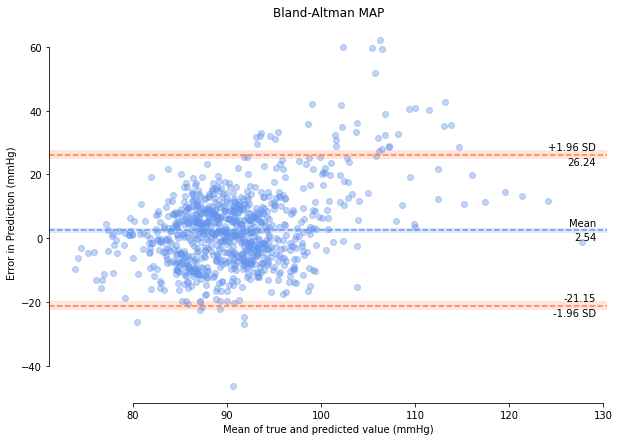

In [ ]:
plot_blandaltman(y_true[6:], x)